## Online dating fraud classification and dataset shift evaluation and mitigation

### Dataset load and preprocessing

In [1]:
import pandas as pd
import re
import math
import numpy as np
from datetime import datetime
import random

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing

In [2]:
# load the csv data files.

datadir = "C:\\Users\\Harrison\\Documents\\Bristol MSc Data Science\\TB-3\\data\\dating\\"
dating_data = pd.read_csv(datadir + "dating_dataset.csv")

jobs_list = pd.read_csv("jobs_list.csv", header = None).values.tolist()
marry_list = pd.read_csv("marry_list.csv", header = None).values.tolist()
location_list = pd.read_csv("location_list.csv", index_col = [0])

In [3]:
# Merge the location data with the main file.
# This location file contains the latitude, longitude, and country information that was found using location_detail_add.ipynb. 

dating_data = dating_data.merge(location_list, on = "location", how = "left")

In [4]:
# Data cleaning and tidy functions for employment, ethnicity, and marriage status. 
# Also puts the timestamp in the correct format for processing. 

def employ(level):
    occupation = "other"
    if str(level) == str(np.nan):
        occupation = np.nan
    else:
        for job in jobs_list:
            if re.findall(job[0], level):
                occupation = job[1]
                break
    return occupation

def marry(level):
    relationship = np.nan
    if str(level) == str(np.nan):
        relationship = np.nan
    else:
        for status in marry_list:
            if re.findall(status[0], level):
                    relationship = status[1]
                    break
    return relationship

def ethnise(level):
    if str(level) ==  str(np.nan):
        level = np.nan
    elif str(level) not in ["asian", "black", "hispanic", "middle eastern", "mixed", 
                            "native american", "pacific islander", "white"]:
        level = "other"
    return level

def timestamp(dating_activity, year_reported, month_reported):
    if str(dating_activity) ==  str(np.nan):
        if str(year_reported) == str(np.nan):
            return np.nan
        else:
            return datetime(int(year_reported),int(month_reported), 1)
    else:
        try:
            dating_activity = dating_activity.replace("'", "")
            dating_activity = datetime.strptime(dating_activity, "%b %d %y")
        except:
            if len(dating_activity) == 6:
                dating_activity = dating_activity + ' 22'
                dating_activity = datetime.strptime(dating_activity, "%b %d %y")
            else:
                dating_activity = np.nan
    return dating_activity

def tidydata(dataset):
    dataset["occupation"] = dataset["occupation"].apply(employ)
    dataset["status"] = dataset["status"].apply(marry)
    dataset["ethnicity"] = dataset["ethnicity"].apply(ethnise)
    dataset['timestamp'] = dataset.apply(lambda x: timestamp(x['last_activity'], x['year_reported'], 
                                                                     x['month_reported']), axis = 1)
    return dataset

In [5]:
# Tidy the data using above functions.

tidydata(dating_data)

username   age  gender ethnicity   occupation    status  \
0                 00  39.0  female     black        carer    single   
1           007raton  40.0    male  hispanic       repair    single   
2            123dean  53.0    male     white     military   married   
3                NaN   NaN     NaN       NaN          NaN       NaN   
4            baryron  37.0    male     white          NaN    single   
...              ...   ...     ...       ...          ...       ...   
105337  Hectorianman  51.0    male     other      medical   widowed   
105338  iamwitnessme  32.0  female     white   technology    single   
105339         heinr  63.0    male     white     military  divorced   
105340      Heinrich  54.0    male     white      medical   widowed   
105341      Heird001  48.0    male     white  engineering   widowed   

         religion                     location  year_reported  month_reported  \
0       Christian   Johannesburg, South Africa            NaN             NaN   
1       Christian            Red Bank, NJ, USA            NaN             NaN   
2       Christian              Marion, AR, USA            NaN             NaN   
3             NaN                          NaN            NaN             NaN   
4           Other     San Pedro Sula, Honduras            NaN             NaN   
...           ...                          ...            ...             ...   
105337        NaN      New York, United States         2021.0             4.0   
105338        NaN               Quebec, Canada         2016.0             9.0   
105339        NaN      New York, United States         2015.0             8.0   
105340        NaN              Bremen, Germany         2019.0             1.0   
105341        NaN  Earth, Texas, United States         2021.0             5.0   

       last_activity  scam   latitude   longitude        country  timestamp  
0         Mar 12 '20     0 -26.205000   28.049722   South Africa 2020-03-12  
1         Jul  3 '15     0  40.347054  -74.064307  United States 2015-07-03  
2         Jun 16 '15     0  36.237852  -92.699956  United States 2015-06-16  
3         Nov 22 '15     0        NaN         NaN            NaN 2015-11-22  
4         Jul  9 '16     0  15.506216  -88.024894       Honduras 2016-07-09  
...              ...   ...        ...         ...            ...        ...  
105337           NaN     1  40.712728  -74.006015  United States 2021-04-01  
105338           NaN     1  52.476089  -71.825867         Canada 2016-09-01  
105339           NaN     1  40.712728  -74.006015  United States 2015-08-01  
105340           NaN     1  53.075820    8.807165    Deutschland 2019-01-01  
105341           NaN     1  34.233137 -102.410749  United States 2021-05-01  

[105342 rows x 16 columns]

In [6]:
# Take out non-unique usernames.
# Maybe consider putting in random fields into username where blank, as do not want to get rid of all blank usernames, bar one! 

dating_data.drop_duplicates('username', inplace = True)

In [7]:
# Select feature set and labels.
# Country is not used in this feature set. 

dating_data_edit = dating_data[['age', 'gender', 'latitude', 'longitude', 
                                'ethnicity', 'occupation', 'status', 'scam', 'timestamp']]

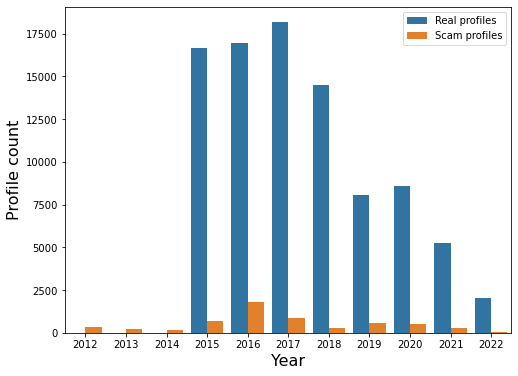

In [8]:
# Inspect the number of profiles at different times. 

dating_data_viz = dating_data[['timestamp', 'scam']]
dating_data_viz = dating_data_viz.dropna(subset = ['timestamp'])
dating_data_viz['year'] = dating_data_viz['timestamp'].dt.year.astype(int)

fig, ax = plt.subplots(figsize = (8, 6))
profile_dates_plot = sns.countplot(data = dating_data_viz, x = 'year', hue = 'scam')

ax.set_xlabel("Year", size = 16)
ax.set_ylabel("Profile count", size = 16)
ax.legend(labels = ['Real profiles', 'Scam profiles'])

profile_dates_plot.figure.savefig("dating_profilecount.png")

In [9]:
# Keep level of consistency with TESSERACT example. Only consider data between 2015 and 2019, that have a timestamp.

dating_data_edit = dating_data_edit.dropna(subset = ['timestamp'])
dating_data_edit = dating_data_edit[dating_data_edit["timestamp"]>'2015-01-01']
dating_data_edit = dating_data_edit[dating_data_edit["timestamp"]<'2021-01-01']

In [10]:
# One-hot encoding to process the categorical data in the dataset. 

cols = ['gender', 'ethnicity', 'occupation', 'status']

dating_data_edit = pd.get_dummies(dating_data_edit, columns = cols, drop_first = True)

In [11]:
# The random forest classifier will only work where all values are present. 

dating_data_rf = dating_data_edit.dropna(axis = 0)

In [12]:
# Create features, labels, and timestamps arrays.

dating_data_edit.reset_index(drop = True, inplace = True)

X = dating_data_edit.drop(['scam', 'timestamp'], axis = 1).to_numpy()
y = np.array(dating_data_edit['scam'])
t = (dating_data_edit['timestamp'])

In [13]:
# Train-test split on both all data and data with no missing values.

from sklearn.model_selection import train_test_split

X_train_og, X_test_og, y_train_og, y_test_og = train_test_split(X, y, test_size = 0.2, random_state = 0)

X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(dating_data_rf.drop(['scam'], axis = 1), 
                                                                dating_data_rf['scam'], 
                                                                test_size = 0.2, random_state = 0)

### Baseline classifier

In [14]:
# Documentation for mixed Naive Bayes classifier is at https://pypi.org/project/mixed-naive-bayes/ 

from sklearn.ensemble import RandomForestClassifier
from mixed_naive_bayes import MixedNB
from sklearn.metrics import classification_report, f1_score, confusion_matrix

nb_clf = MixedNB()
nb_clf.fit(X_train_og, y_train_og)
nb_pred = nb_clf.predict(X_test_og)

rf_clf = RandomForestClassifier(random_state = 123)
rf_clf.fit(X_train_rf.drop(['timestamp'], axis = 1), y_train_rf)
rf_pred = rf_clf.predict(X_test_rf.drop(['timestamp'], axis = 1))

print(nb_clf.score(X_test_og, y_test_og))
print(rf_clf.score(X_test_rf.drop(['timestamp'], axis = 1), y_test_rf))

print("\n")

print(f1_score(nb_pred, y_test_og))
print(f1_score(rf_pred, y_test_rf))

[]
0.9467411757997377
0.9747634069400631


0.0
0.7326607818411098


In [15]:
# Try Histogram based Gradient-Boosting Classifier
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingClassifier.html
# https://github.com/scikit-learn/scikit-learn/issues/15079

from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from sklearn.model_selection import GridSearchCV

hgbc_clf = HistGradientBoostingClassifier(random_state = 123)

# Set the different hyperparameters to search through.

hgbc_param_grid = {
    "learning_rate": [0.05, 0.1, 0.2, 0.5, 1],
    "max_leaf_nodes": [2, 4, 16, 31],
    "max_iter": [100, 250]
}

# Perform the grid search. 

hgbc_gridsearch = GridSearchCV(estimator = hgbc_clf,
                         param_grid = hgbc_param_grid,
                         scoring = "f1",
                         cv = 10)

hgbc_gridsearch_model = hgbc_gridsearch.fit(X_train_og, y_train_og)

In [16]:
# View the model hyperparameters that had the highest performance. 

hgbc_gridsearch_model.best_params_

{'learning_rate': 0.1, 'max_iter': 250, 'max_leaf_nodes': 31}

In [17]:
# Test the performance of the histogram gradient boosting classifier on the test dataset. 

hgbc_clf = HistGradientBoostingClassifier(learning_rate = hgbc_gridsearch_model.best_params_['learning_rate'],
                                          max_iter = hgbc_gridsearch_model.best_params_['max_iter'],
                                          max_leaf_nodes = hgbc_gridsearch_model.best_params_['max_leaf_nodes'],
                                          random_state = 123)
hgbc_clf.fit(X_train_og, y_train_og)
hgbc_pred = hgbc_clf.predict(X_test_og)

print(f1_score(hgbc_pred, y_test_og))

0.7697715289982425


In [18]:
# Print the classification report for the HGBC classifier on the test set.

from sklearn.metrics import classification_report, f1_score, confusion_matrix

print(classification_report(y_test_og, hgbc_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99     16603
           1       0.85      0.70      0.77       934

    accuracy                           0.98     17537
   macro avg       0.92      0.85      0.88     17537
weighted avg       0.98      0.98      0.98     17537



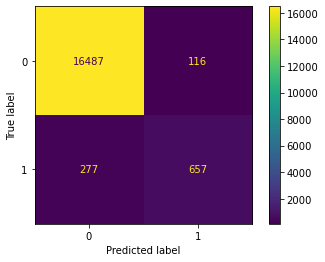

In [19]:
# Print and save the confusion matrix for the HGBC classifier on the test set. 

from sklearn.metrics import plot_confusion_matrix

cfm_plot = plot_confusion_matrix(hgbc_clf, X_test_og, y_test_og)

# cfm_plot.savefig("cfm.png")

In [20]:
# Set baseline F1 score for later visualisation purposes.

baseline_f1 = [f1_score(hgbc_pred, y_test_og)]

### Dataset shift evaluation and mitigation using TESSERACT

In [21]:
from ml_tesseract import evaluation, temporal, metrics, mock, viz_hb, spatial

In [22]:
# What is the best split for the temporal adjustment of the dataset?
# Below runs several combinations and considers minimum size of window and label ratio.

training_time_list = [12, 18, 24]
testing_time_list = [1, 3, 4, 6]
temporal_split_metrics = []

for training_time in training_time_list:
    for testing_time in testing_time_list:
        train_idx, test_idx = temporal.time_aware_indexes(t, training_time, testing_time, granularity='month')
        min_counter = len(y)
        min_pos_counter = len(np.extract(y == 1, y))
        prop_counter = np.mean(y)

        for i in range(len(test_idx)):
            if min_counter > len(y[test_idx[i]]):
                min_counter = len(y[test_idx[i]])
            if min_pos_counter > len(np.extract(y[test_idx[i]] == 1, y[test_idx[i]])):
                min_pos_counter = len(np.extract(y[test_idx[i]] == 1, y[test_idx[i]]))
            if prop_counter > np.mean(y[test_idx[i]]):
                prop_counter = np.mean(y[test_idx[i]])
        
        temporal_split_metrics.append([training_time, testing_time, min_counter, min_pos_counter, np.round(prop_counter*100,2)])

In [23]:
# Use this code to convert the dataframe into a latex table to used in the dissertation. 

print(pd.DataFrame(temporal_split_metrics, columns = ['Training time (months)', 'Testing windows (months)', 
                                                       'Minimum testing window sample size', 
                                                       'Minimum testing window positive sample size',
                                                       'Minimum positive ratio']).to_latex(index = False))

\begin{tabular}{rrrrr}
\toprule
 Training time (months) &  Testing windows (months) &  Minimum testing window sample size &  Minimum testing window positive sample size &  Minimum positive ratio \\
\midrule
                     12 &                         1 &                                 303 &                                            0 &                    0.00 \\
                     12 &                         3 &                                1574 &                                            0 &                    0.00 \\
                     12 &                         4 &                                2099 &                                           77 &                    1.78 \\
                     12 &                         6 &                                3528 &                                          153 &                    1.90 \\
                     18 &                         1 &                                 303 &                                      

In [24]:
# Split the data in a temporally consistent fashion. 18 months to train and 6 months for testing window size. 

splits = temporal.time_aware_train_test_split(X, y, t,
                                              train_size=18, test_size=6, granularity='month')

X_train, X_tests, y_train, y_tests, t_train, t_tests = splits

# Put the data into a format that is correctly read by the TESSERACT package.

splits_C12 = X_train, X_tests, y_train, y_tests, np.array(t_train, dtype = 'object'), np.array(t_tests, dtype = 'object') 

In [25]:
# Create a new split set that also meets the C3 constraint, which is spatial.
# A range of between 7.5% and 12.5% is used for the enforced ratio.
# Note that this is a random process, and will therefore change on different runs of this script. 

X_tests_C3 = []
y_tests_C3 = []
t_tests_C3 = []

for i in range(0, len(y_tests)):
    if spatial.assert_class_distribution(y_tests[i], 0.1, 0.025) == False:
        X_C3, y_C3, t_C3 = spatial.downsample_set(X_tests[i], y_tests[i], np.array(t_tests[i]), 0.075, 0.125)
        X_tests_C3.append(X_C3)
        y_tests_C3.append(y_C3)
        t_tests_C3.append(t_C3)
    else:
        X_tests_C3.append(X_tests[i])
        y_tests_C3.append(y_tests[i])
        t_tests_C3.append(t_tests[i])

splits_C123 = (X_train, X_tests_C3, y_train, y_tests_C3, 
               np.array(t_train, dtype = 'object'), np.array(t_tests_C3, dtype = 'object')) 

**Dataset shift evaluation**

In [26]:
# Train and evaluate the model under temporal constraints (C1 and C2).

hgbc_clf = HistGradientBoostingClassifier(learning_rate = hgbc_gridsearch_model.best_params_['learning_rate'],
                                          max_iter = hgbc_gridsearch_model.best_params_['max_iter'],
                                          max_leaf_nodes = hgbc_gridsearch_model.best_params_['max_leaf_nodes'],
                                          random_state = 123)

results_C12 = evaluation.fit_predict_update(hgbc_clf, *splits_C12)

metrics.print_metrics(results_C12)
print(metrics.aut(results_C12, 'f1'))

9it [00:15,  1.72s/it]

------------+---------------------------------------------------------------
Test period |     1      2      3      4      5      6      7      8      9   
------------+---------------------------------------------------------------
Actual pos  |   1336    551    206    158    238    195    350    304    153
Actual neg  |   8802  10436   7677   8172   6289   4815   3178   4353   4165
Total       |  10138  10987   7883   8330   6527   5010   3528   4657   4318
------------+---------------------------------------------------------------
TPR         |  0.624  0.617  0.578  0.582  0.580  0.462  0.520  0.500  0.444
FPR         |  0.005  0.006  0.005  0.006  0.010  0.008  0.010  0.009  0.011
TNR         |  0.995  0.994  0.995  0.994  0.990  0.992  0.990  0.991  0.989
FNR         |  0.376  0.383  0.422  0.418  0.420  0.538  0.480  0.500  0.556
------------+---------------------------------------------------------------
Precision   |  0.948  0.840  0.739  0.648  0.693  0.692  0.847  0.788  0.6

In [27]:
# Train and evaluate the model under temporal and spatial constraints (C1, C2, and C3).

hgbc_clf = HistGradientBoostingClassifier(learning_rate = hgbc_gridsearch_model.best_params_['learning_rate'],
                                          max_iter = hgbc_gridsearch_model.best_params_['max_iter'],
                                          max_leaf_nodes = hgbc_gridsearch_model.best_params_['max_leaf_nodes'],
                                          random_state = 123)

results_C123 = evaluation.fit_predict_update(hgbc_clf, *splits_C123)

metrics.print_metrics(results_C123)
print(metrics.aut(results_C123, 'f1'))

9it [00:15,  1.72s/it]

------------+---------------------------------------------------------------
Test period |     1      2      3      4      5      6      7      8      9   
------------+---------------------------------------------------------------
Actual pos  |   1257    551    206    158    238    195    350    304    153
Actual neg  |   8802   6795   2540   1948   2935   2405   3178   3749   1887
Total       |  10059   7346   2746   2106   3173   2600   3528   4053   2040
------------+---------------------------------------------------------------
TPR         |  0.631  0.617  0.578  0.582  0.580  0.462  0.520  0.500  0.444
FPR         |  0.005  0.006  0.006  0.007  0.006  0.007  0.010  0.010  0.009
TNR         |  0.995  0.994  0.994  0.993  0.994  0.993  0.990  0.990  0.991
FNR         |  0.369  0.383  0.422  0.418  0.420  0.538  0.480  0.500  0.556
------------+---------------------------------------------------------------
Precision   |  0.945  0.890  0.895  0.876  0.890  0.849  0.847  0.804  0.8

**Dataset shift mitigation**

In [28]:
# Train and evaluate the model with classification with rejection at 80%. 

from ml_tesseract.rejection import ThresholdRejector

hgbc_clf = HistGradientBoostingClassifier(learning_rate = hgbc_gridsearch_model.best_params_['learning_rate'],
                                          max_iter = hgbc_gridsearch_model.best_params_['max_iter'],
                                          max_leaf_nodes = hgbc_gridsearch_model.best_params_['max_leaf_nodes'],
                                          random_state = 123)

rejector = ThresholdRejector('<', 0.80)
results_thresh = evaluation.fit_predict_update(hgbc_clf, *splits_C123, rejectors=[rejector])

metrics.print_metrics(results_thresh)
print(metrics.aut(results_thresh, 'f1'))

9it [00:15,  1.73s/it]

------------+---------------------------------------------------------------
Test period |     1      2      3      4      5      6      7      8      9   
------------+---------------------------------------------------------------
Actual pos  |    845    365    133     99    164    126    217    190     96
Actual neg  |   8674   6678   2502   1919   2879   2365   3101   3669   1844
Total       |   9519   7043   2635   2018   3043   2491   3318   3859   1940
------------+---------------------------------------------------------------
TPR         |  0.673  0.682  0.632  0.636  0.604  0.468  0.512  0.511  0.438
FPR         |  0.001  0.002  0.001  0.002  0.002  0.003  0.004  0.005  0.006
TNR         |  0.999  0.998  0.999  0.998  0.998  0.997  0.996  0.995  0.994
FNR         |  0.327  0.318  0.368  0.364  0.396  0.532  0.488  0.489  0.562
------------+---------------------------------------------------------------
Precision   |  0.988  0.958  0.966  0.955  0.952  0.908  0.910  0.843  0.7

In [29]:
# Train and evaluate the model with uncertainy sampling at 20%. 

from ml_tesseract.selection import UncertaintySamplingSelector

hgbc_clf = HistGradientBoostingClassifier(learning_rate = hgbc_gridsearch_model.best_params_['learning_rate'],
                                          max_iter = hgbc_gridsearch_model.best_params_['max_iter'],
                                          max_leaf_nodes = hgbc_gridsearch_model.best_params_['max_leaf_nodes'],
                                          random_state = 123)

selector = UncertaintySamplingSelector('20%')
results_uncertsamp = evaluation.fit_predict_update(hgbc_clf, *splits_C123, selectors=[selector])

metrics.print_metrics(results_uncertsamp)
print(metrics.aut(results_uncertsamp, 'f1'))

9it [00:22,  2.54s/it]

------------+---------------------------------------------------------------
Test period |     1      2      3      4      5      6      7      8      9   
------------+---------------------------------------------------------------
Actual pos  |   1257    551    206    158    238    195    350    304    153
Actual neg  |   8802   6795   2540   1948   2935   2405   3178   3749   1887
Total       |  10059   7346   2746   2106   3173   2600   3528   4053   2040
------------+---------------------------------------------------------------
TPR         |  0.631  0.719  0.660  0.696  0.664  0.641  0.689  0.694  0.712
FPR         |  0.005  0.007  0.006  0.007  0.007  0.010  0.013  0.008  0.006
TNR         |  0.995  0.993  0.994  0.993  0.993  0.990  0.987  0.992  0.994
FNR         |  0.369  0.281  0.340  0.304  0.336  0.359  0.311  0.306  0.288
------------+---------------------------------------------------------------
Precision   |  0.945  0.896  0.901  0.894  0.883  0.845  0.858  0.879  0.9

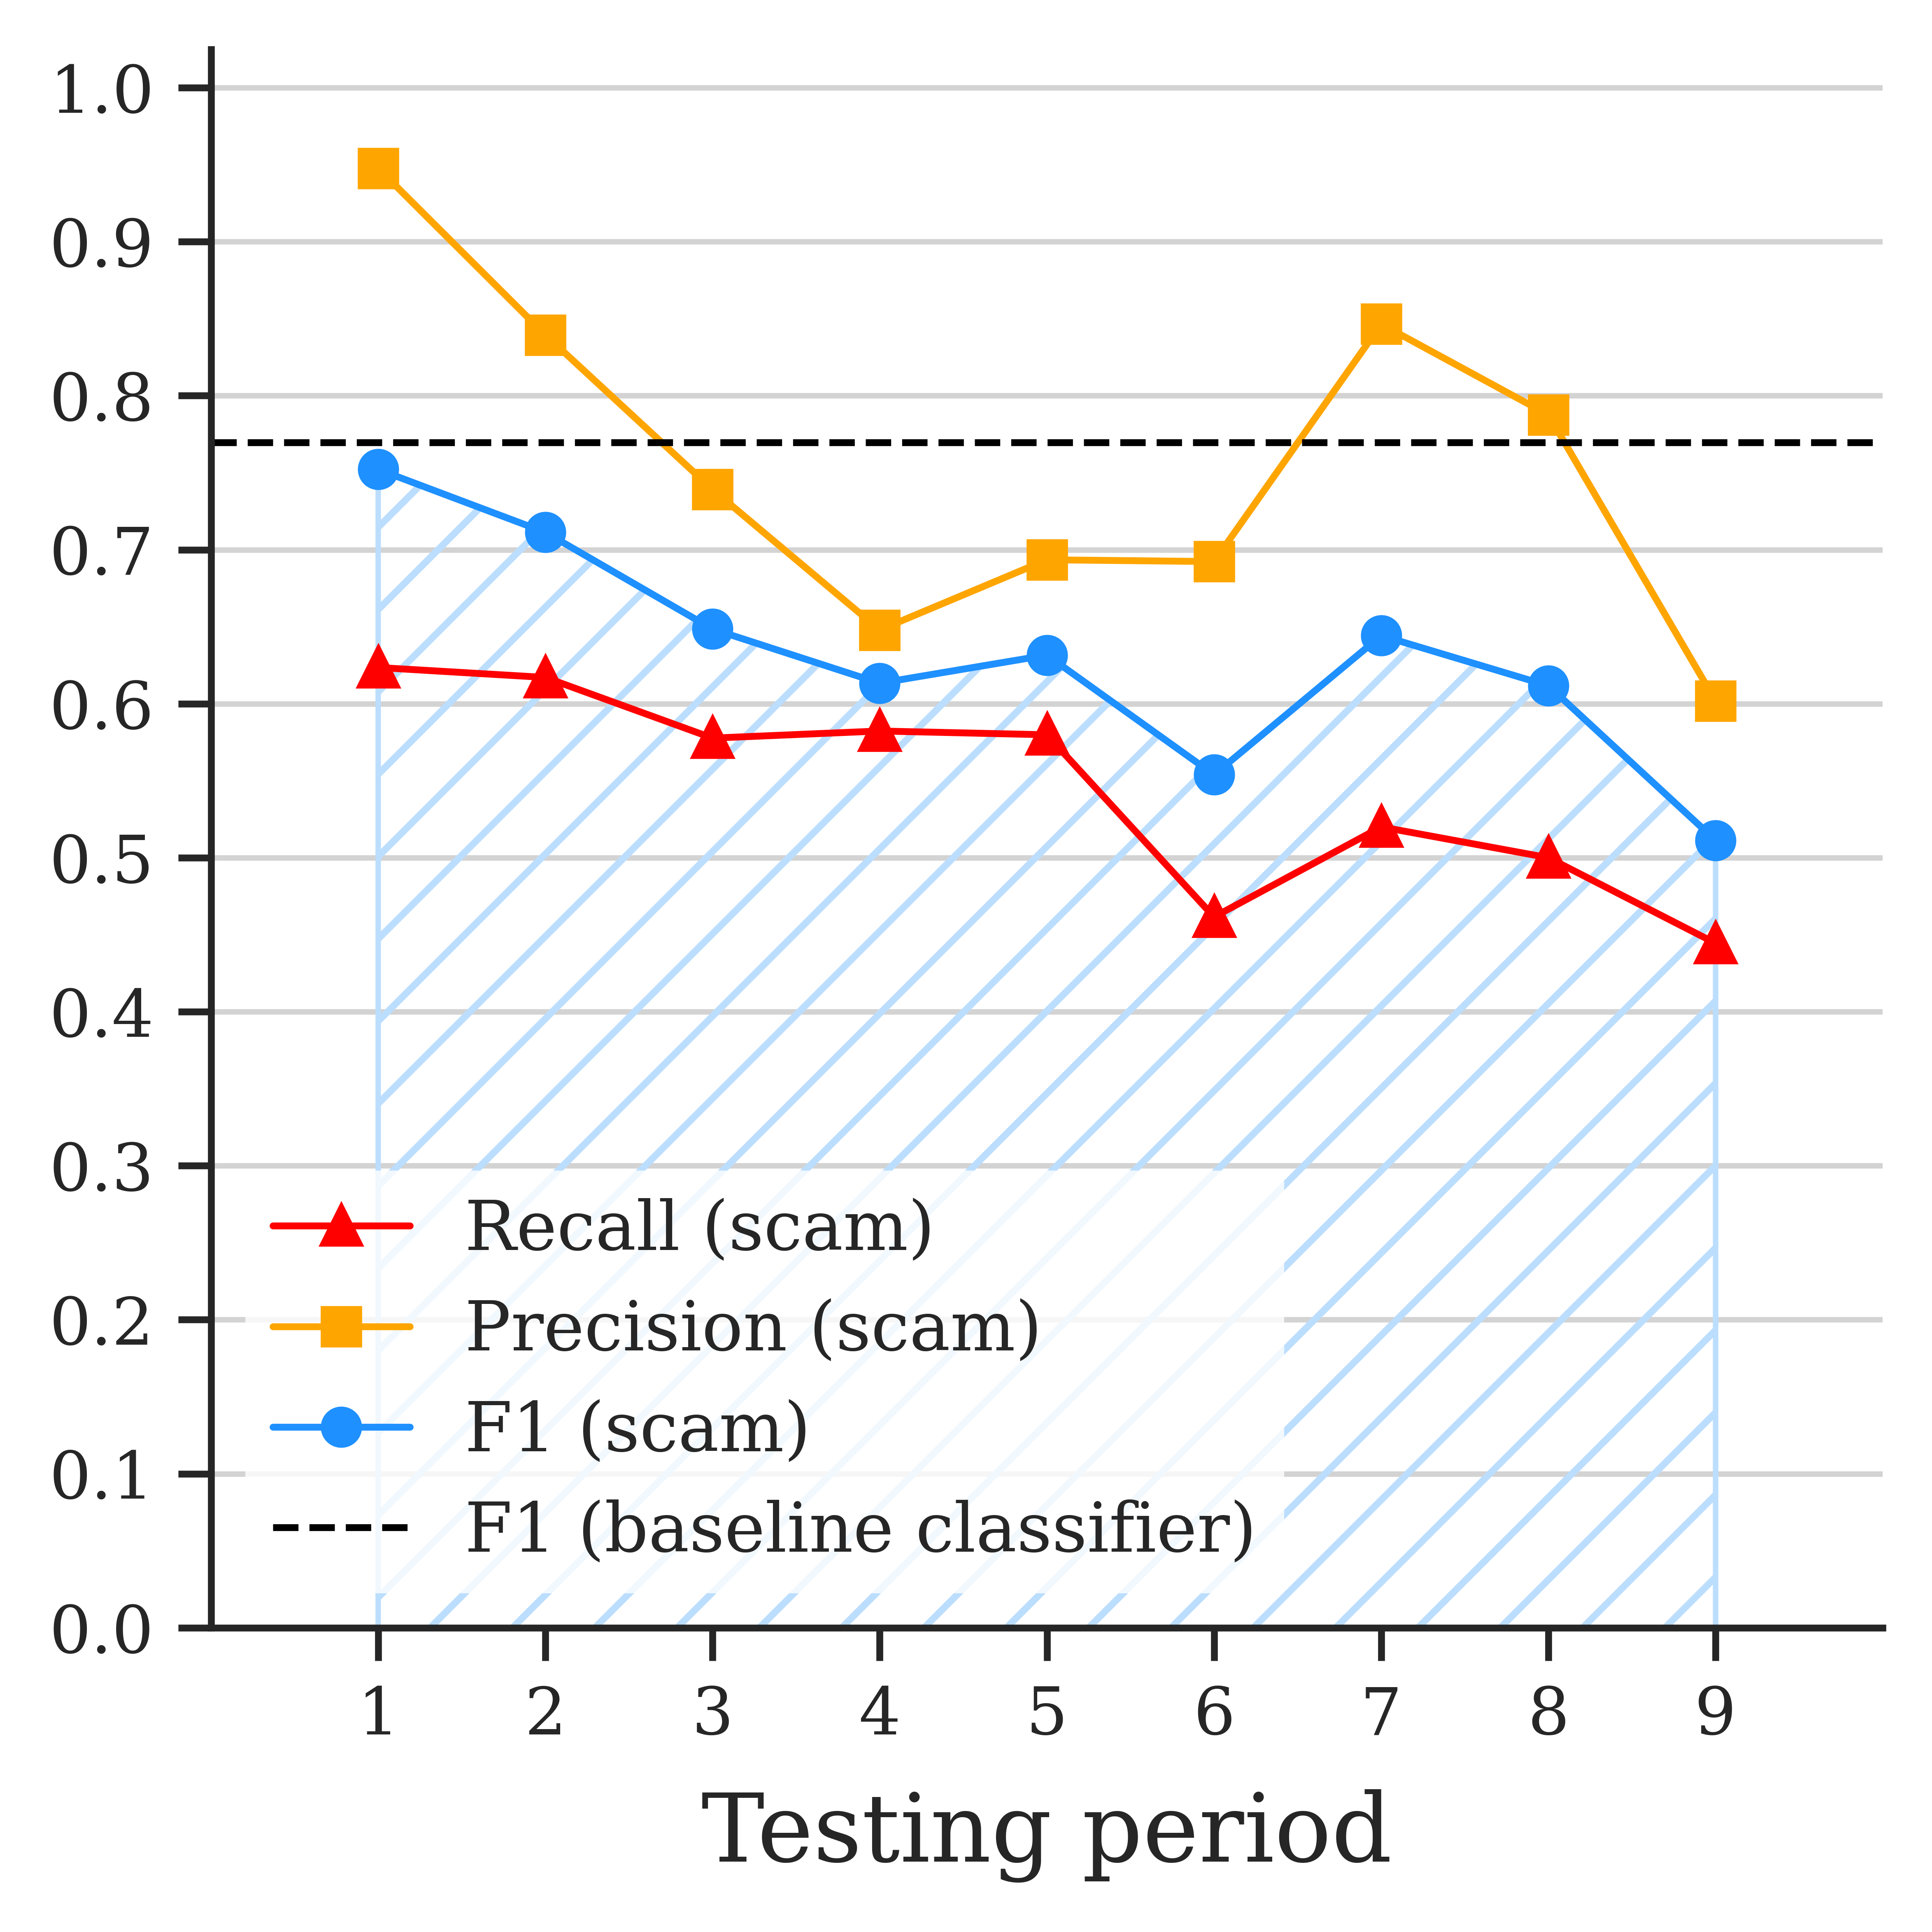

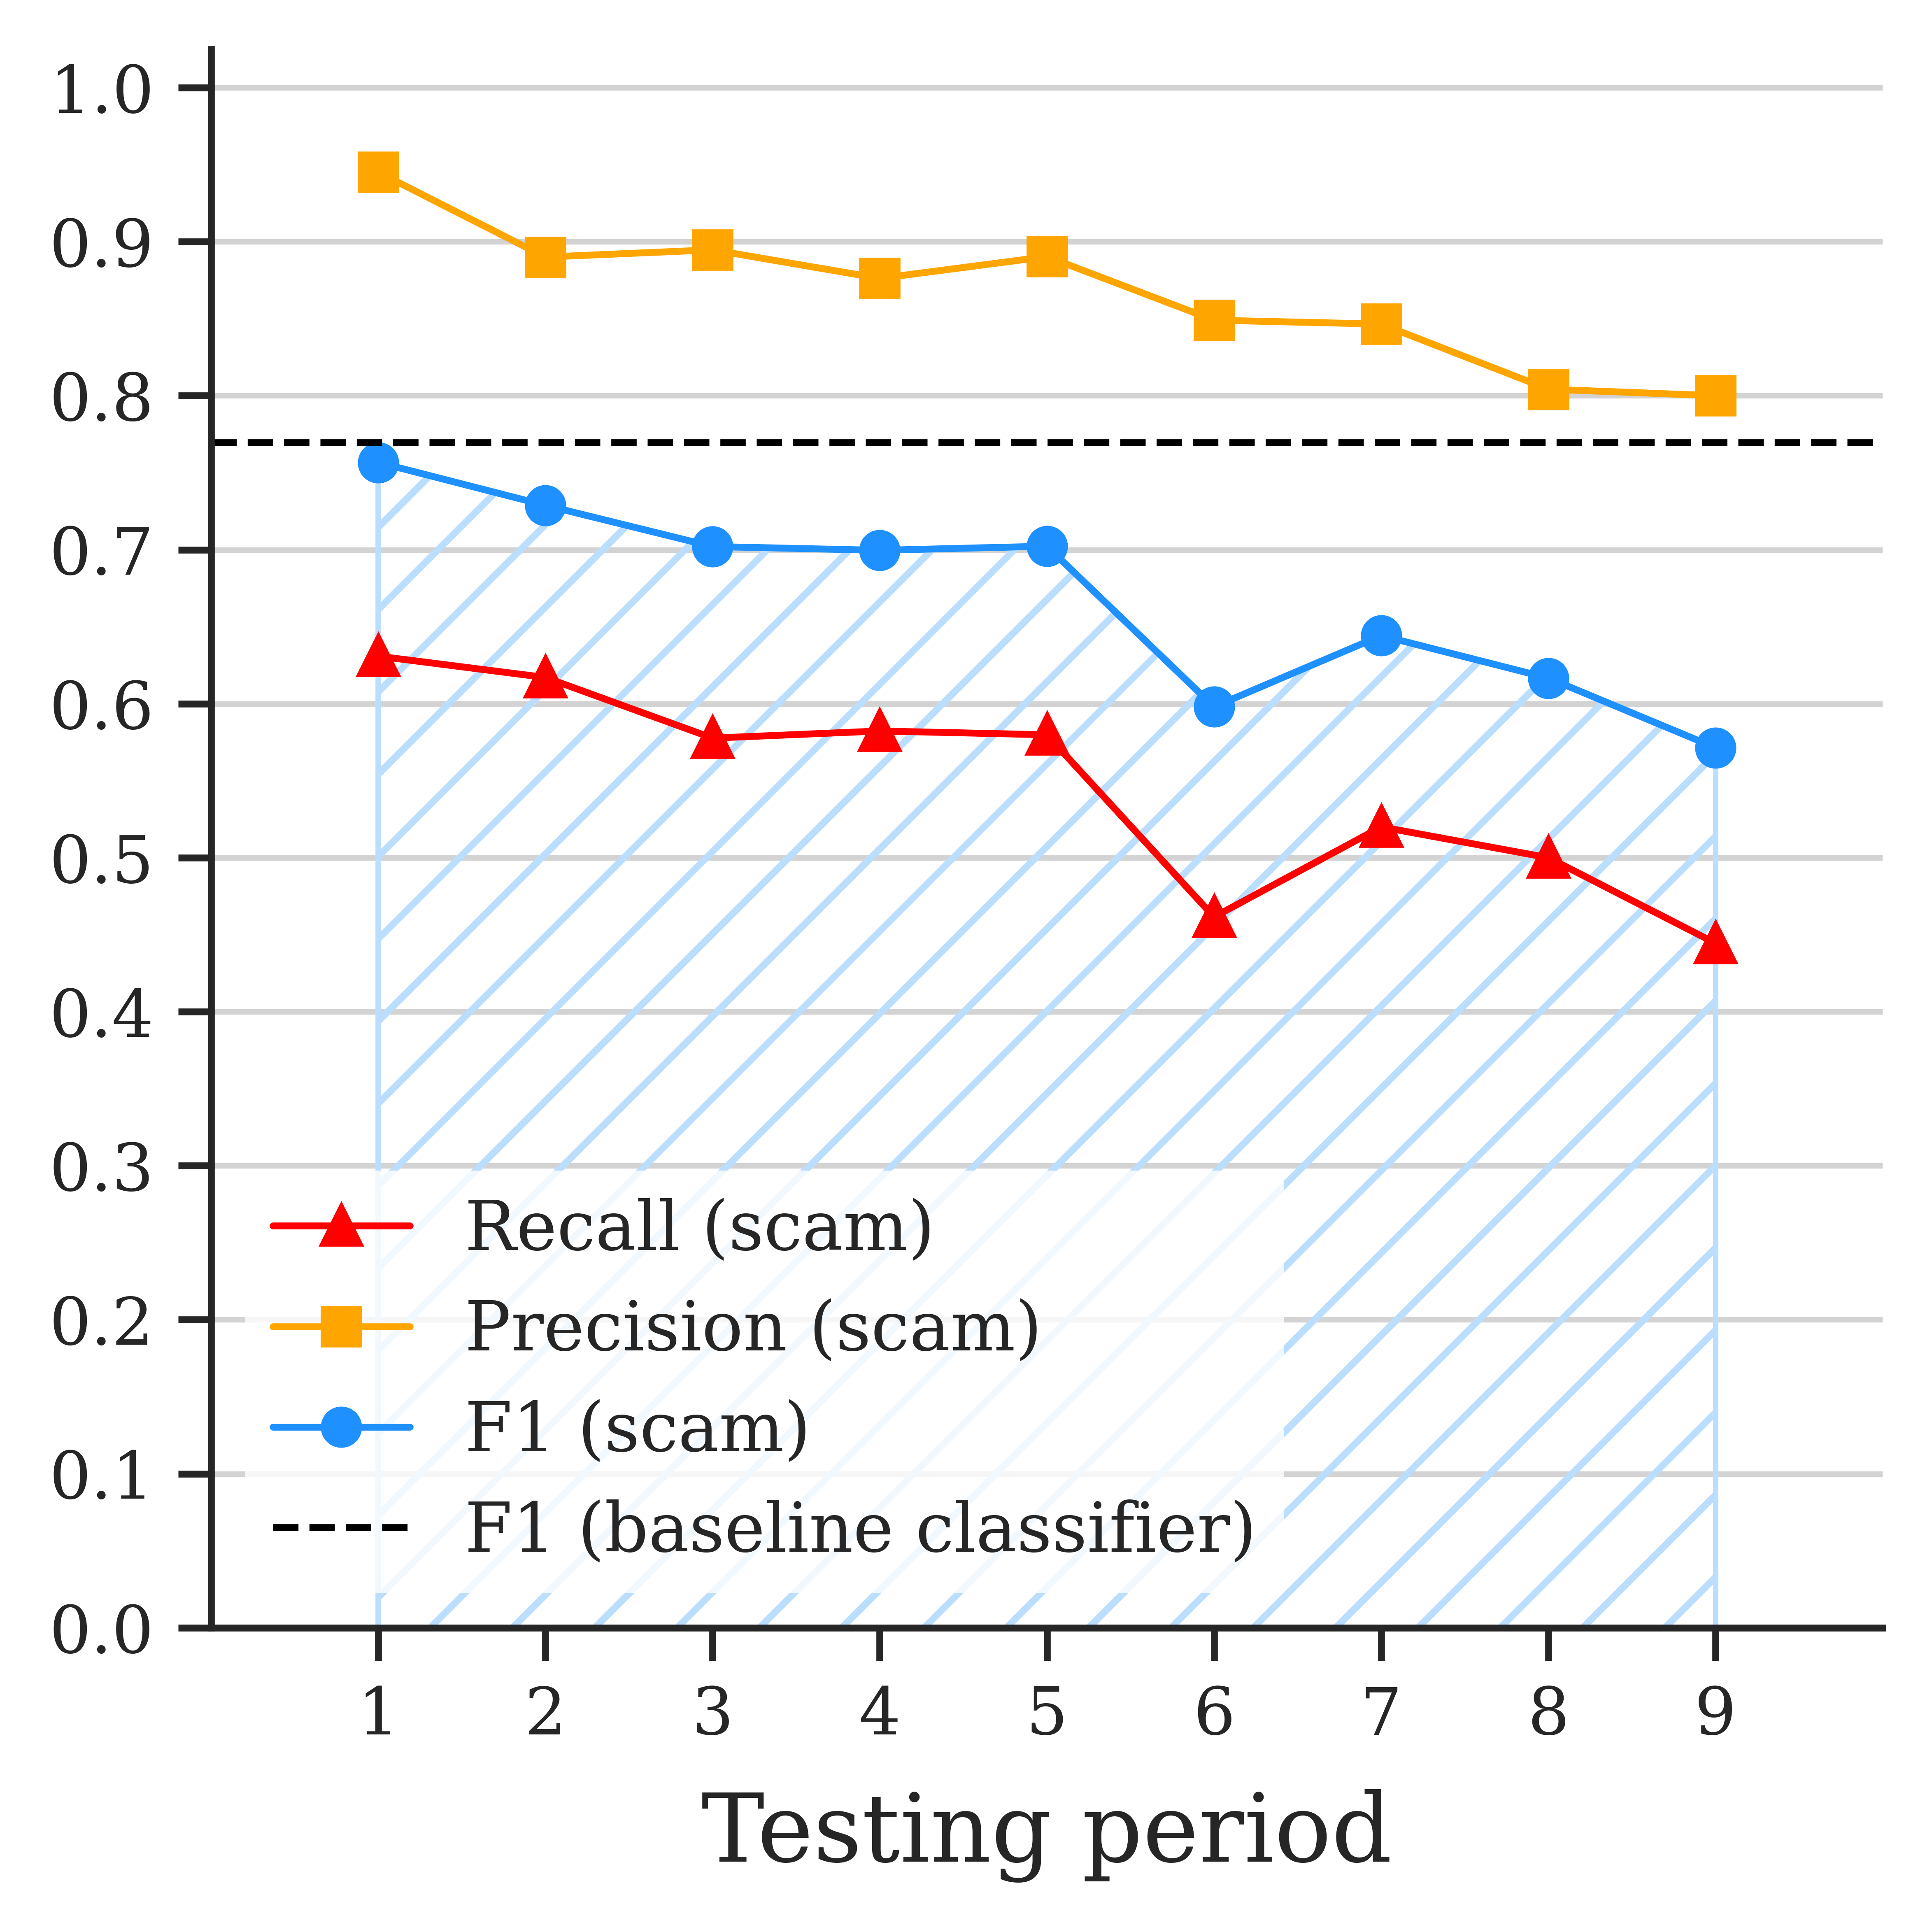

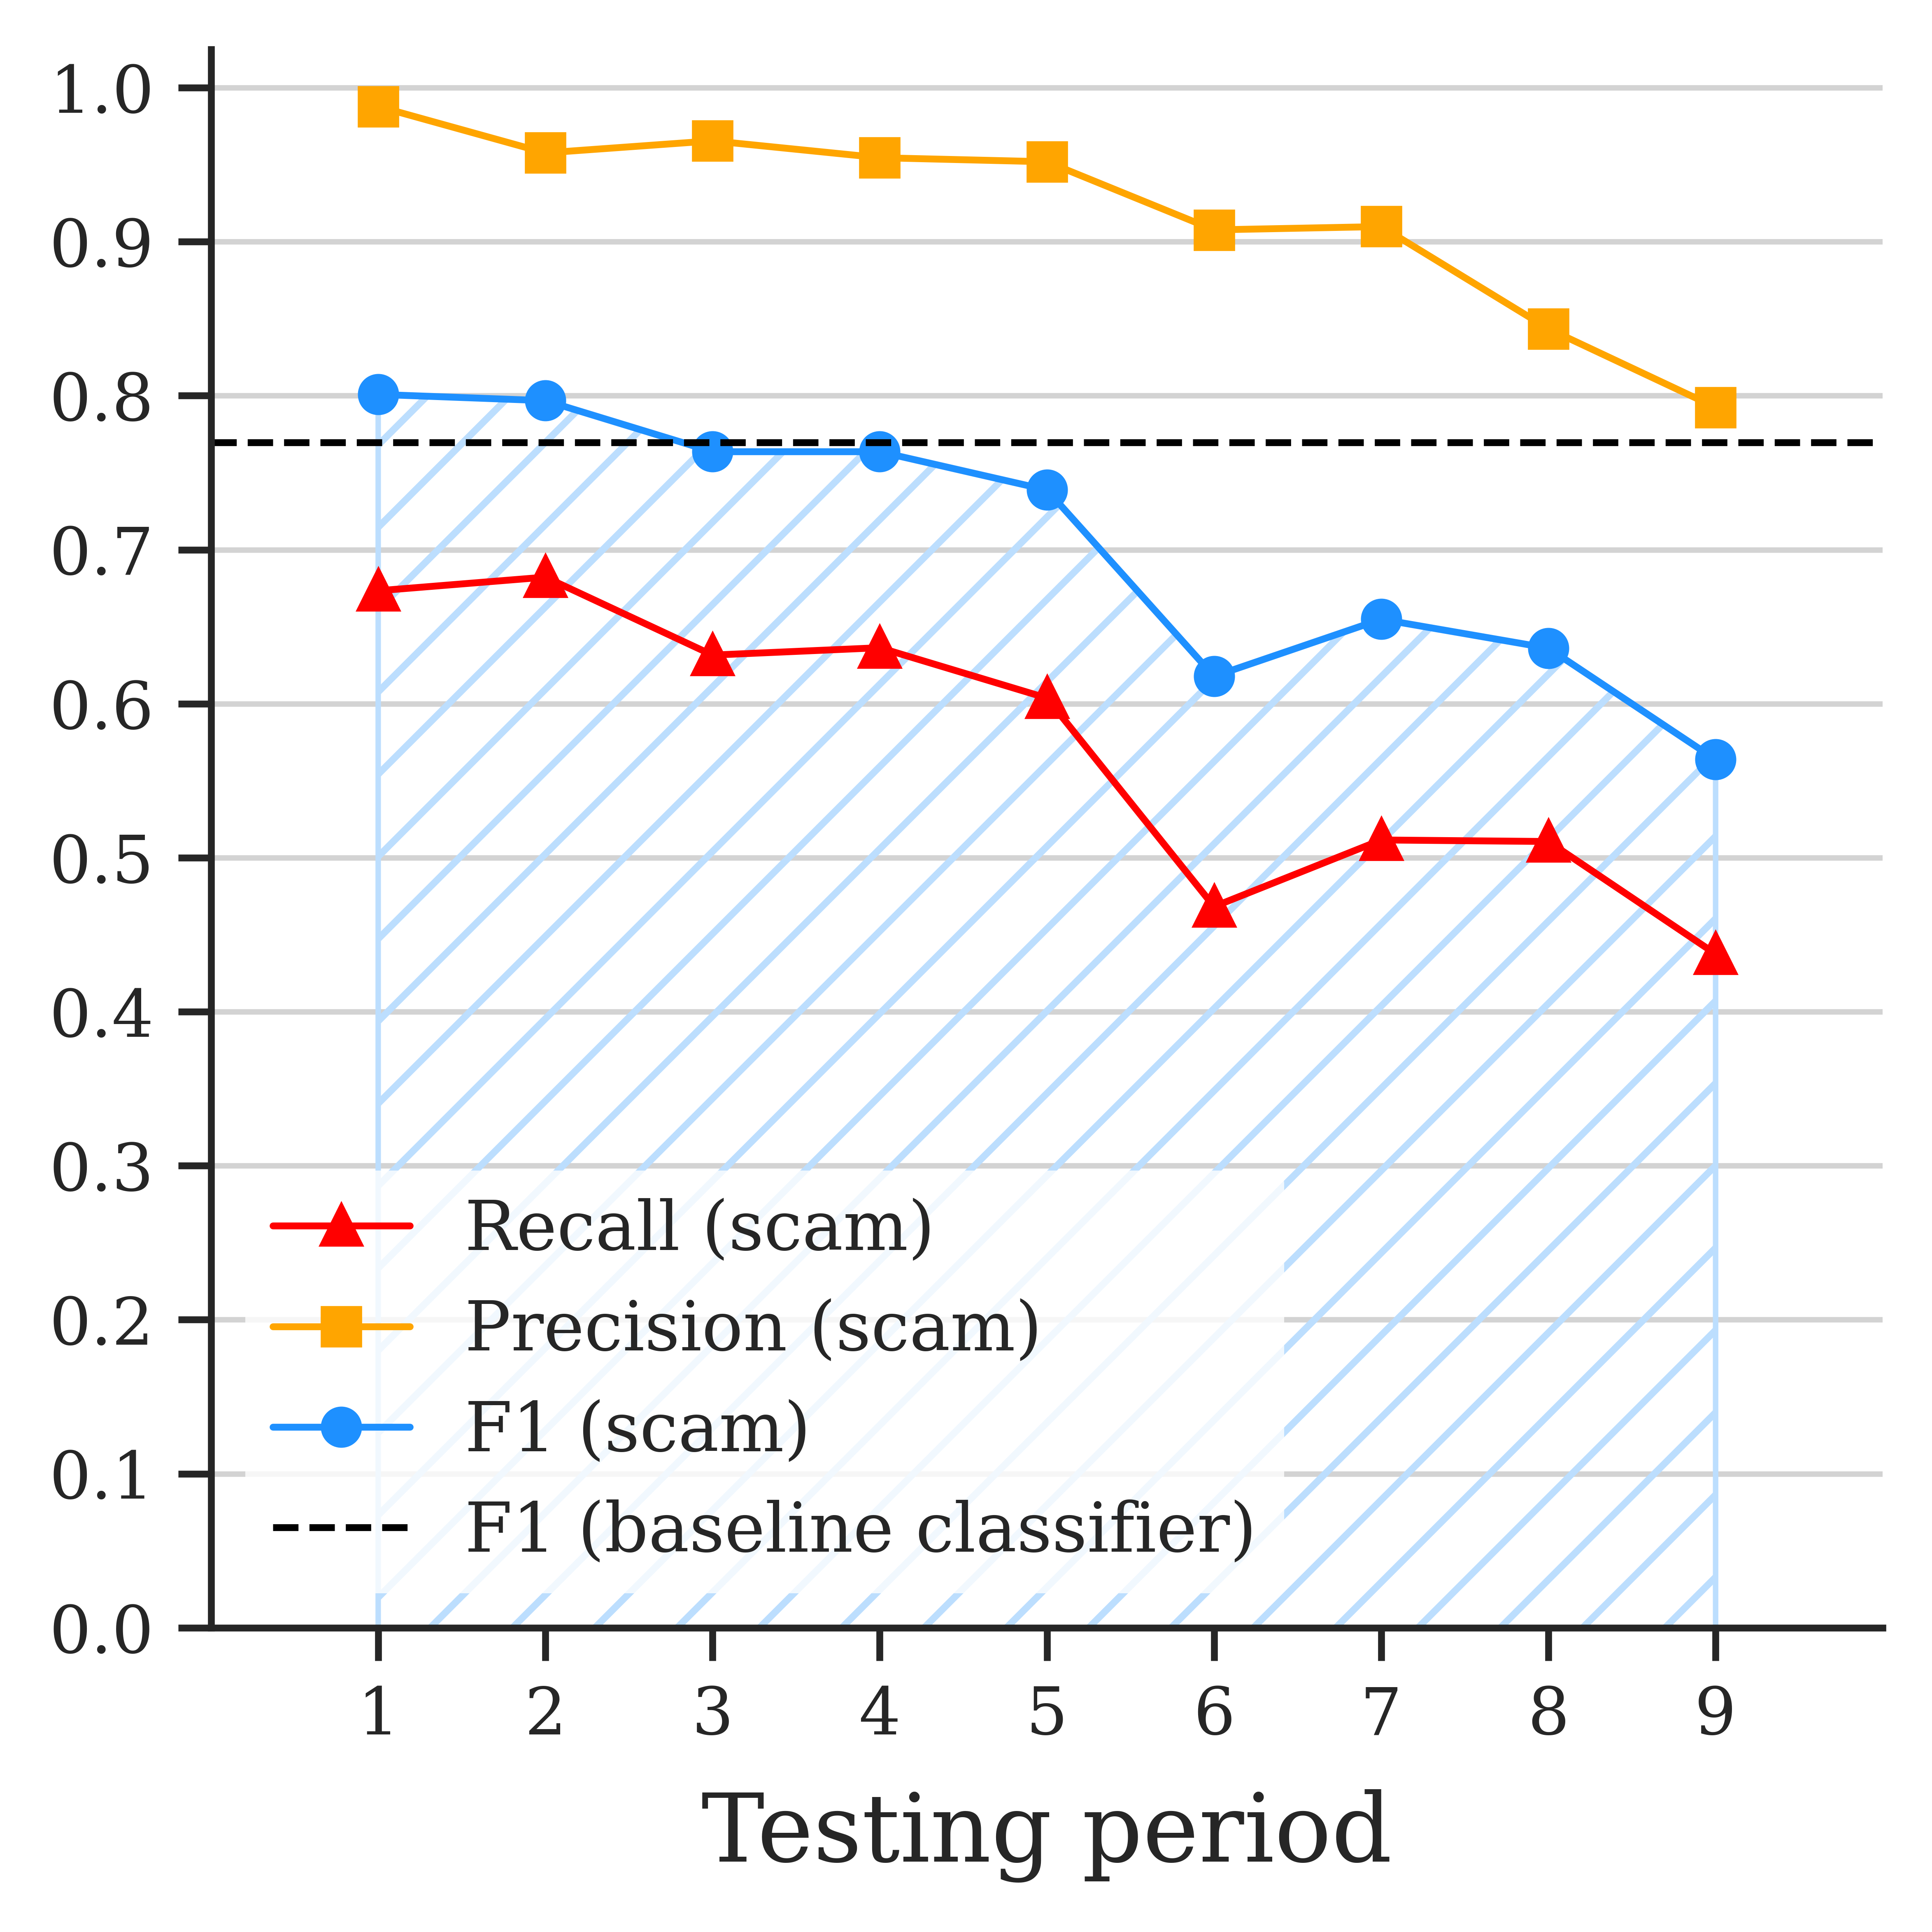

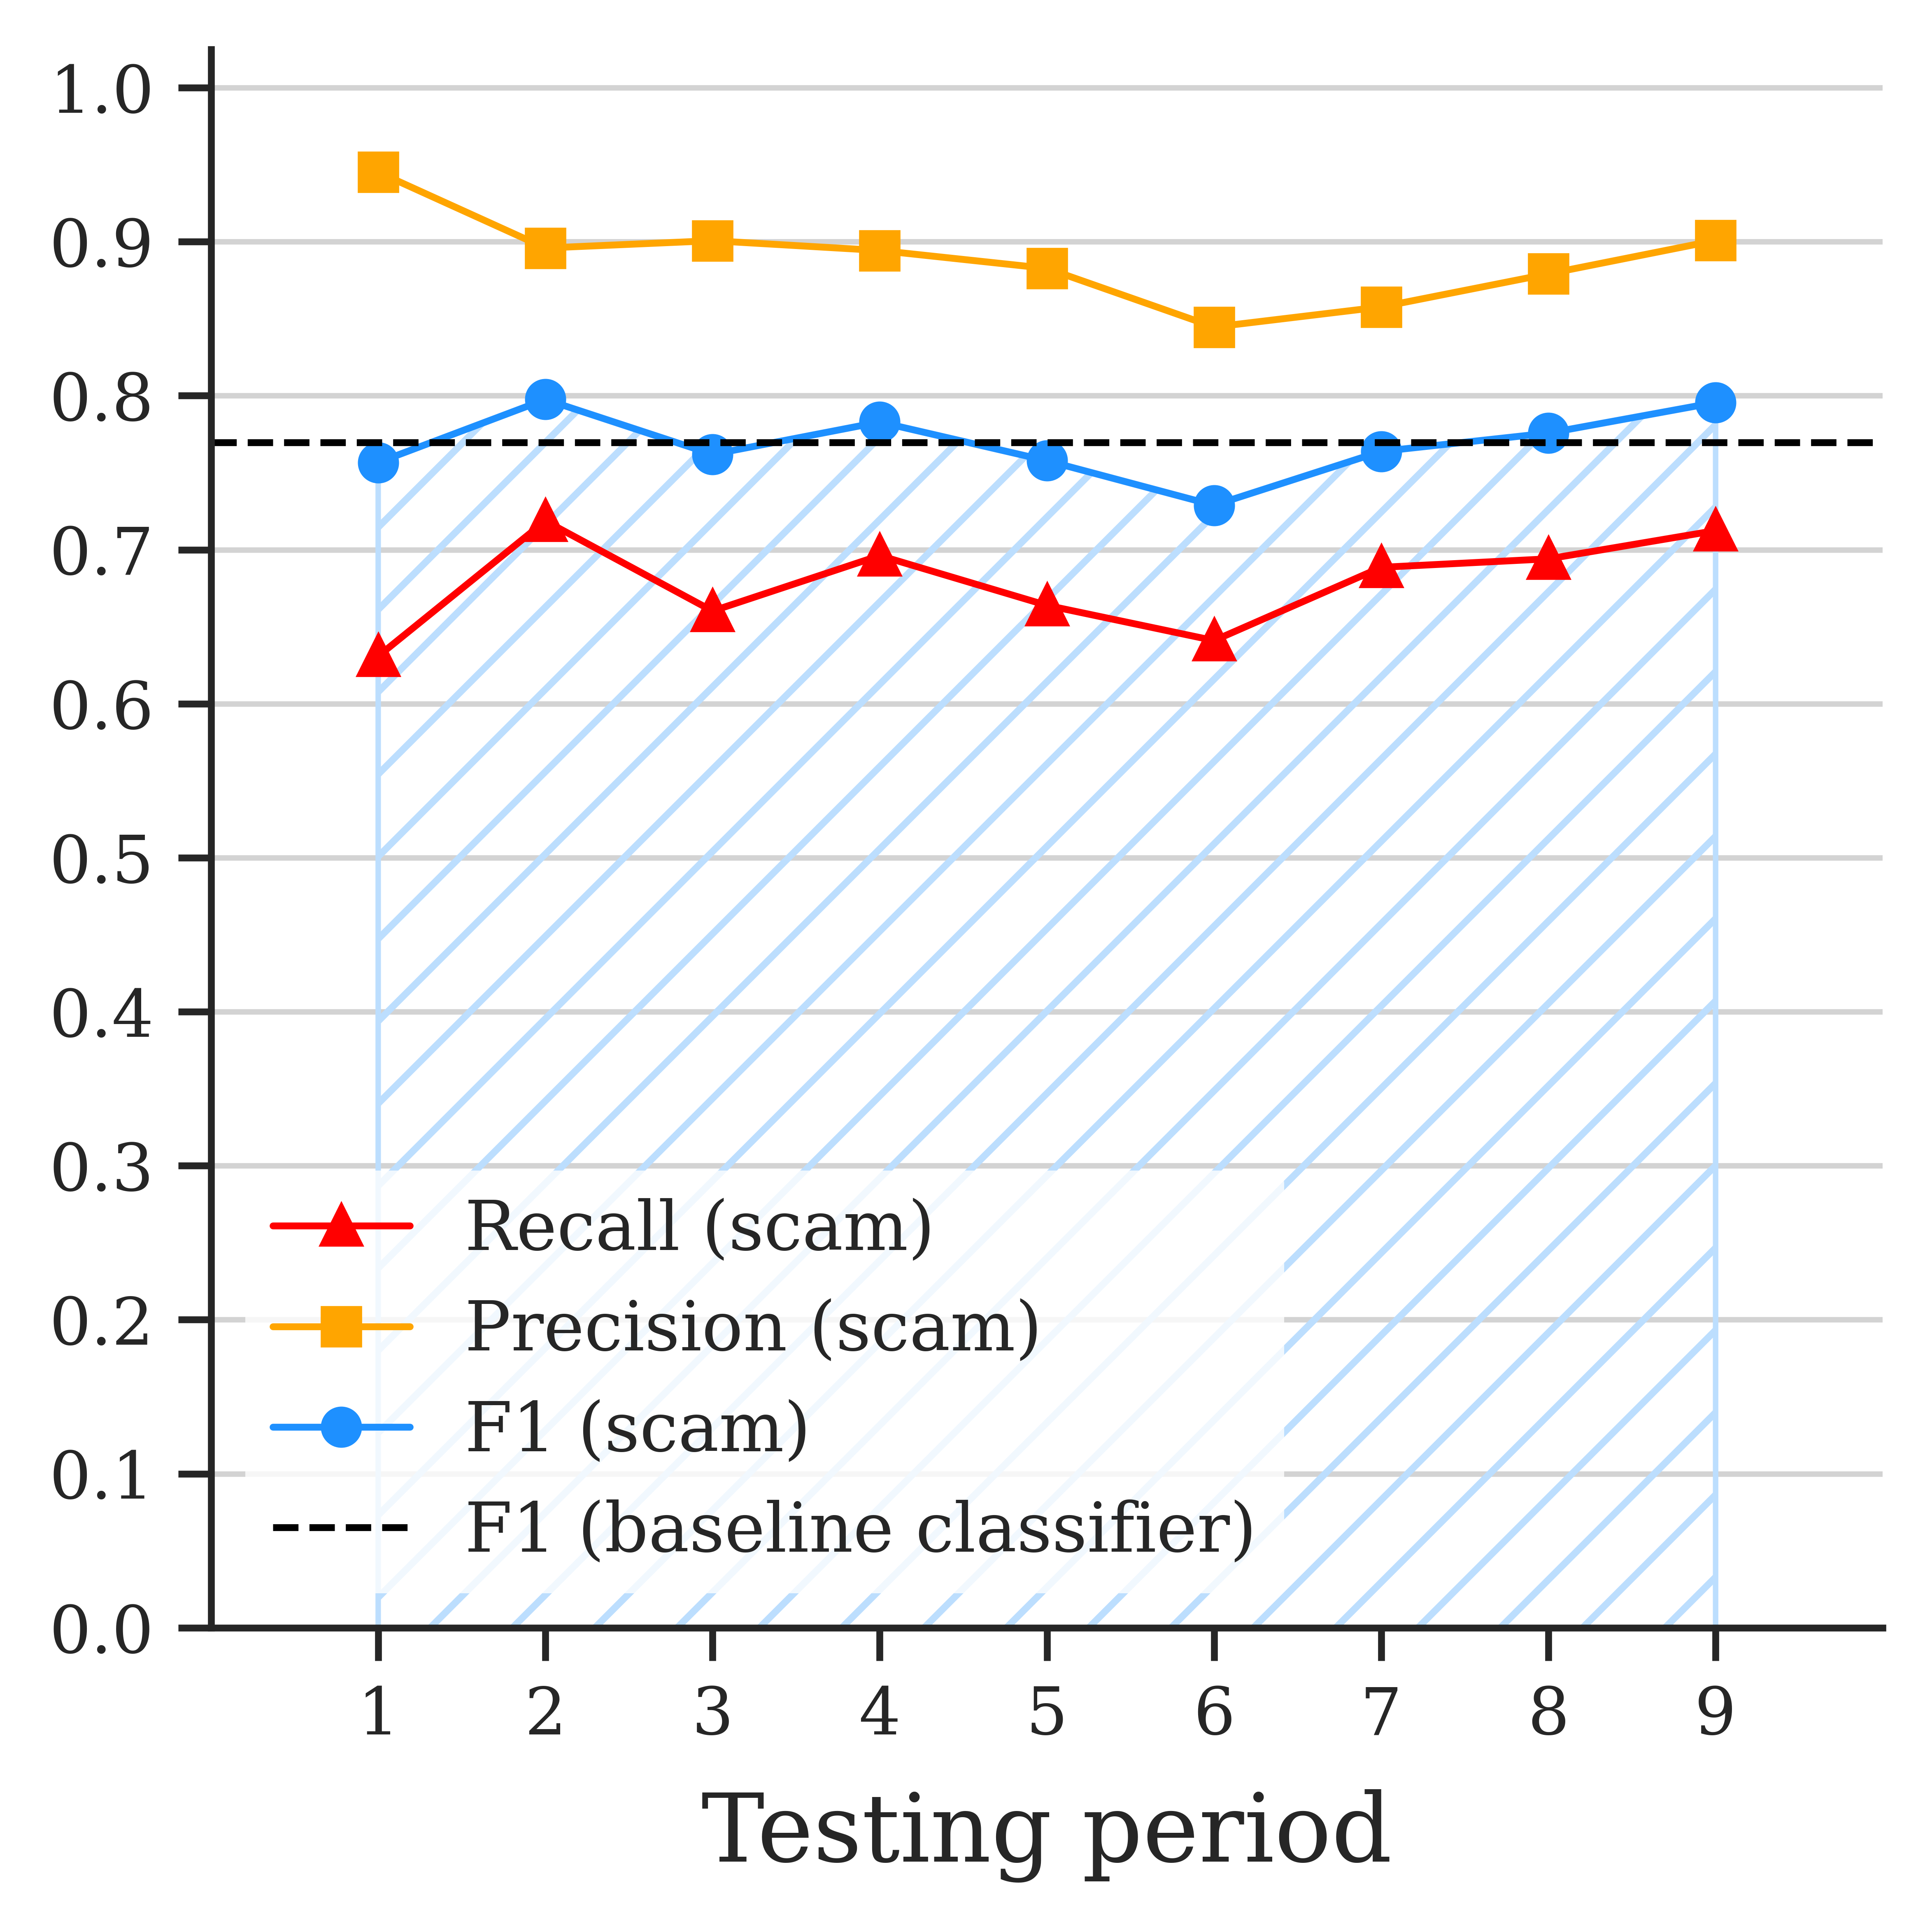

In [30]:
# Save the visualisations for evaluation and mitigation of dataset shift. 

viz_hb.plot_decay(results_C12, means = baseline_f1).savefig("C12_dating.png")
viz_hb.plot_decay(results_C123, means = baseline_f1).savefig("C123_dating.png")
viz_hb.plot_decay(results_thresh, means = baseline_f1).savefig("thresh_dating.png")
viz_hb.plot_decay(results_uncertsamp, means = baseline_f1).savefig("uncertsamp_dating.png")

In [31]:
# Examine classification with rejection using different thresholds. 

threshs = [0.5, 0.6, 0.70, 0.80, 0.90, 0.95, 0.99]

for thresh_level in threshs:
    
    hgbc_clf = HistGradientBoostingClassifier(learning_rate = hgbc_gridsearch_model.best_params_['learning_rate'],
                                          max_iter = hgbc_gridsearch_model.best_params_['max_iter'],
                                          max_leaf_nodes = hgbc_gridsearch_model.best_params_['max_leaf_nodes'],
                                          random_state = 123)

    rejector = ThresholdRejector('<', thresh_level)
    results_thresh_cycle = evaluation.fit_predict_update(hgbc_clf, *splits_C123, rejectors=[rejector])
    
    print(thresh_level)
    print(metrics.aut(results_thresh_cycle, 'f1'))

9it [00:15,  1.70s/it]


0.5
0.6694684678888354


9it [00:15,  1.73s/it]


0.6
0.6792509365780854


9it [00:15,  1.72s/it]


0.7
0.6971500813413659


9it [00:15,  1.77s/it]


0.8
0.7067392509301993


9it [00:15,  1.71s/it]


0.9
0.7130925578377876


9it [00:15,  1.73s/it]


0.95
0.7225929721954002


9it [00:15,  1.72s/it]

0.99
0.622491646522319


In [32]:
# Examine uncertainty sampling using different thresholds. 

uncertsamps = ['1%', '5%', '10%', '20%']

for uncertsamp_level in uncertsamps:
    
    hgbc_clf = HistGradientBoostingClassifier(learning_rate = hgbc_gridsearch_model.best_params_['learning_rate'],
                                          max_iter = hgbc_gridsearch_model.best_params_['max_iter'],
                                          max_leaf_nodes = hgbc_gridsearch_model.best_params_['max_leaf_nodes'],
                                          random_state = 123)

    selector = UncertaintySamplingSelector(uncertsamp_level)
    results_uncertsamp_cycle = evaluation.fit_predict_update(hgbc_clf, *splits_C123, selectors=[selector])
    
    print(uncertsamp_level)
    print(metrics.aut(results_uncertsamp_cycle, 'f1'))

9it [00:15,  1.72s/it]


1%
0.699870606849015


9it [00:20,  2.22s/it]


5%
0.7503357295679866


9it [00:22,  2.49s/it]


10%
0.7612018131977508


9it [00:22,  2.51s/it]

20%
0.7681018521768257


In [33]:
# Train a classifier with no constraints, but a smaller dataset for comparison. 

X_train_smaller, _, y_train_smaller, _ = train_test_split(X_train_og, y_train_og, 
                                                          test_size = len(X_train)/len(X_train_og), random_state = 0)

    
hgbc_clf = HistGradientBoostingClassifier(learning_rate = hgbc_gridsearch_model.best_params_['learning_rate'],
                                          max_iter = hgbc_gridsearch_model.best_params_['max_iter'],
                                          max_leaf_nodes = hgbc_gridsearch_model.best_params_['max_leaf_nodes'],
                                          random_state = 123)
hgbc_clf.fit(X_train_smaller, y_train_smaller)
hgbc_pred_smaller = hgbc_clf.predict(X_test_og)

print(classification_report(y_test_og, hgbc_pred_smaller))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99     16603
           1       0.84      0.69      0.76       934

    accuracy                           0.98     17537
   macro avg       0.91      0.84      0.87     17537
weighted avg       0.98      0.98      0.98     17537



## Feature set differences

**Visual comparison**

In [34]:
# Recreate the temporal split and use this to create new dataframes, that are based on the original dataframe. 
# These new dataframes are for the training window and the last testing window. 
# Use the original dataframe as this will be easier to visualise in charts, since this is before dummy variables have been used.

train_idx, test_idx = temporal.time_aware_indexes(t, train_size=18, test_size=6, granularity='month')

X_0 = dating_data.iloc[train_idx][['status', 'occupation', 'ethnicity', 'gender', 'age', 'scam']]
X_9 = dating_data.iloc[test_idx[8]][['status', 'occupation', 'ethnicity', 'gender', 'age', 'scam']]

In [35]:
# Create dataframes that calculate the percentages for marriage status, occupation and ethnicity.
# This is calculated for both scam and real profiles. 

X_0_pc_status = pd.DataFrame(X_0.groupby(['scam'])['status'].value_counts(normalize=True))
X_0_pc_status.rename(columns = {'status': 'percentage'}, inplace = True)
X_0_pc_status.percentage = np.round(X_0_pc_status.percentage*100,2)
X_0_pc_status = X_0_pc_status.reset_index()

X_9_pc_status = pd.DataFrame(X_9.groupby(['scam'])['status'].value_counts(normalize=True))
X_9_pc_status.rename(columns = {'status': 'percentage'}, inplace = True)
X_9_pc_status.percentage = np.round(X_9_pc_status.percentage*100,2)
X_9_pc_status = X_9_pc_status.reset_index()

X_0_pc_ethnicity = pd.DataFrame(X_0.groupby(['scam'])['ethnicity'].value_counts(normalize=True))
X_0_pc_ethnicity.rename(columns = {'ethnicity': 'percentage'}, inplace = True)
X_0_pc_ethnicity.percentage = np.round(X_0_pc_ethnicity.percentage*100,2)
X_0_pc_ethnicity = X_0_pc_ethnicity.reset_index()

X_9_pc_ethnicity = pd.DataFrame(X_9.groupby(['scam'])['ethnicity'].value_counts(normalize=True))
X_9_pc_ethnicity.rename(columns = {'ethnicity': 'percentage'}, inplace = True)
X_9_pc_ethnicity.percentage = np.round(X_9_pc_ethnicity.percentage*100,2)
X_9_pc_ethnicity = X_9_pc_ethnicity.reset_index()

X_0_pc_occupation = pd.DataFrame(X_0.groupby(['scam', 'gender'])['occupation'].value_counts(normalize = True))
X_0_pc_occupation.rename(columns = {'occupation': 'percentage'}, inplace = True)
X_0_pc_occupation.percentage = np.round(X_0_pc_occupation.percentage*100,2)

X_9_pc_occupation = pd.DataFrame(X_9.groupby(['scam', 'gender'])['occupation'].value_counts(normalize = True))
X_9_pc_occupation.rename(columns = {'occupation': 'percentage'}, inplace = True)
X_9_pc_occupation.percentage = np.round(X_9_pc_occupation.percentage*100,2)

In [36]:
# Plot marriage status percentages for training window. 

fig, ax = plt.subplots(figsize = (8, 6))
status_dating_plot_0 = sns.barplot(data = X_0_pc_status, y = 'status', x = 'percentage', hue = 'scam')

ax.set_xlabel("Percentage", size = 16)
ax.set_ylabel("Marriage status", size = 16)

ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])

status_dating_plot_0.figure.savefig("status_dating_plot_0.png")

In [37]:
# Plot marriage status percentages for 9th test window. 

fig, ax = plt.subplots(figsize = (8, 6))
status_dating_plot_9 = sns.barplot(data = X_9_pc_status, y = 'status', x = 'percentage', hue = 'scam')

ax.set_xlabel("Percentage", size = 16)
ax.set_ylabel("Marriage status", size = 16)

ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])

status_dating_plot_9.figure.savefig("status_dating_plot_9.png")

In [38]:
# Plot ethnicity percentages for training window. 

fig, ax = plt.subplots(figsize = (10, 8))
ethnicity_dating_plot_0 = sns.barplot(data = X_0_pc_ethnicity, y = 'ethnicity', x = 'percentage', hue = 'scam')

ax.set_xlabel("Percentage", size = 16)
ax.set_ylabel("Ethnicity", size = 16)

ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])

ethnicity_dating_plot_0.figure.savefig("ethnicity_dating_plot_0.png")

In [39]:
# Plot ethnicity percentages for 9th test window. 

fig, ax = plt.subplots(figsize = (10, 8))
ethnicity_dating_plot_9 = sns.barplot(data = X_9_pc_ethnicity, y = 'ethnicity', x = 'percentage', hue = 'scam')

ax.set_xlabel("Percentage", size = 16)
ax.set_ylabel("Ethnicity", size = 16)

ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])

ethnicity_dating_plot_9.figure.savefig("ethnicity_dating_plot_9.png")

In [40]:
# Occupation proportions for training window.

X_0_pc_occupation.percentage.groupby(level=[0,1]).nlargest(5)

scam  gender  scam  gender  occupation   
0     female  0     female  other            15.83
                            student           9.04
                            carer             7.31
                            service           6.70
                            teacher           6.33
      male    0     male    other            16.89
                            engineering       9.01
                            self-employed     6.39
                            technology        5.92
                            service           4.41
1     female  1     female  self-employed    15.57
                            student          13.86
                            other            11.09
                            carer            10.87
                            military          6.18
      male    1     male    military         28.68
                            engineering      21.14
                            self-employed     9.93
                            other       

In [41]:
# Occupation proportions for 9th test window.

X_9_pc_occupation.percentage.groupby(level=[0,1]).nlargest(5)

scam  gender  scam  gender  occupation   
0     female  0     female  other            18.34
                            student           9.64
                            carer             7.10
                            clerical          6.43
                            service           6.02
      male    0     male    other            16.68
                            engineering       9.29
                            self-employed     7.46
                            technology        5.36
                            service           5.08
1     female  1     female  self-employed    20.63
                            student          17.46
                            military          9.52
                            carer             7.94
                            service           7.94
      male    1     male    military         29.69
                            engineering      18.75
                            self-employed    10.94
                            medical     

**Testing for dataset difference using a classifier**

In [42]:
# Create a combined dataset of the training window and the 9th test window.
# Label the training window instances as 0s and the test window instances as 1s.

X_09_difference = np.concatenate([X_train[y_train==1], X_tests[8][y_tests[8]==1]])
y_09_difference = np.concatenate((np.zeros(len(X_train[y_train==1])), np.ones(len(X_tests[8][y_tests[8]==1]))))

X_09_difference = np.concatenate([X_train, X_tests[8]])
y_09_difference = np.concatenate((np.zeros(len(X_train)), np.ones(len(X_tests[8]))))

In [43]:
# Train-test split on the combined dataset.

X_train_difference, X_test_difference, y_train_difference, y_test_difference = train_test_split(
    X_09_difference, y_09_difference, test_size = 0.2, random_state = 0)

In [44]:
# Test the performance for predicting the correct dataset, using a hgbc classifier. 

hgbc_clf = HistGradientBoostingClassifier(random_state = 123)
hgbc_clf.fit(X_train_difference, y_train_difference)
hgbc_pred = hgbc_clf.predict(X_test_difference)

print(hgbc_clf.score(X_test_difference, y_test_difference))

print("\n")

print(f1_score(hgbc_pred, y_test_difference))

0.868734693877551


0.16249999999999998


In [45]:
# Print the classification report for the dataset window classifier. 

print(classification_report(y_test_difference, hgbc_pred))

              precision    recall  f1-score   support

         0.0       0.87      0.99      0.93      5275
         1.0       0.71      0.09      0.16       850

    accuracy                           0.87      6125
   macro avg       0.79      0.54      0.55      6125
weighted avg       0.85      0.87      0.82      6125

